In [1]:
import sys
sys.path.append("..")

from core.DataLoader import DataPreprocessor
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import keras

MAX_JETS = 4
PLOTS_DIR = f"plots/"
import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

DataProcessor = DataPreprocessor(
    jet_features=[
        "ordered_jet_pt",
        "ordered_jet_e",
        "ordered_jet_phi",
        "ordered_jet_eta",
        "ordered_jet_b_tag",
        "m_l1j",
        "m_l2j",
        "dR_l1j",
        "dR_l2j",
    ],
    lepton_features=["lep_pt", "lep_e", "lep_eta", "lep_phi"],
    jet_truth_label="ordered_event_jet_truth_idx",
    lepton_truth_label="event_lepton_truth_idx",
    global_features=["met_met_NOSYS", "met_phi_NOSYS"],
    max_leptons=2,
    max_jets=MAX_JETS,
    non_training_features=["truth_ttbar_mass", "truth_ttbar_pt", "N_jets"],
    regression_targets=["truth_ttbar_mass"],
    event_weight="weight_mc_NOSYS",
)

DataProcessor.load_data(
    "/data/dust/group/atlas/ttreco/full_training.root", "reco", max_events=100000
)
DataProcessor.prepare_data()
#DataProcessor.normalise_data()
DataProcessor.split_data(0.2)


2025-06-27 10:53:43.636755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 10:53:43.644537: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 10:53:43.648872: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 10:53:43.657810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751014423.672427 3702806 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751014423.67

In [2]:
import core.TransformerRegression as TMR
import core.RegressionKFold as RKF

reload(RKF)
reload(TMR)


transformer = RKF.RegressionKFold(TMR.SimpleRegression, data_processor=DataProcessor, n_folds = 5, n_splits = 1)
transformer.build_models(
        hidden_size=16,
        number_attention_heads=8,
        transformer_layers=3,
        ff_layers=2,
        dropout_rate=0.05,
        regularization_lambda=0.001,
    )
#transformer.load_model("/data/dust/group/atlas/ttreco/16_1_1_4_0.05_0.001_0.5/jet_matcher.keras")
#transformer = TMR.RegressionTransformer(DataProcessor); transformer.load_data(*DataProcessor.get_data())
#transformer.compute_sample_weights()
transformer.compile_models(optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = {"assignment_output": "accuracy", "regression_output": "mse"}),
transformer.train_models(epochs=2, batch_size=512, verbose=1, weight="sample")
#transformer.save_model("spa_net_test.keras")

2025-06-27 10:53:58.990256: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Starting training...
Starting training...
Starting training...
Starting training...
Starting training...
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
156/156 ━━━━━━━━━━━━━━━━━━━━ 143s 118ms/step - assignment_output_accuracy: 0.6522 - assignment_output_loss: 2.5186 - loss: 1134.9651 - regression_output_loss: 1132.2216 - regression_output_mse: 304835821568.0000 - val_assignment_output_accuracy: 0.6494 - val_assignment_output_loss: 1.6783 - val_loss: 1145.3378 - val_regression_output_loss: 1144.2766 - val_regression_output_mse: 308123238400.0000
149/156 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - assignment_output_accuracy: 0.7126 - assignment_output_loss: 2.6612 - loss: 1140.3921 - regression_output_loss: 1137.4281 - regression_output_mse: 308369915904.0000Epoch 2/2
156/156 ━━━━━━━━━━━━━━━━━━━━ 147s 111ms/step - assignment_output_accuracy: 0.7248 - assignment_output_loss: 2.6580 - loss: 1138.5295 - regression_output_loss: 1135.6805 - regression_output_mse: 307096846336.0000 - val_assignment

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Confusion Matrix for Lepton 1 (Bootstrap)'}, xlabel='Predicted Label', ylabel='True Label'>,
        <Axes: title={'center': 'Confusion Matrix for Lepton 2 (Bootstrap)'}, xlabel='Predicted Label', ylabel='True Label'>],
       dtype=object))

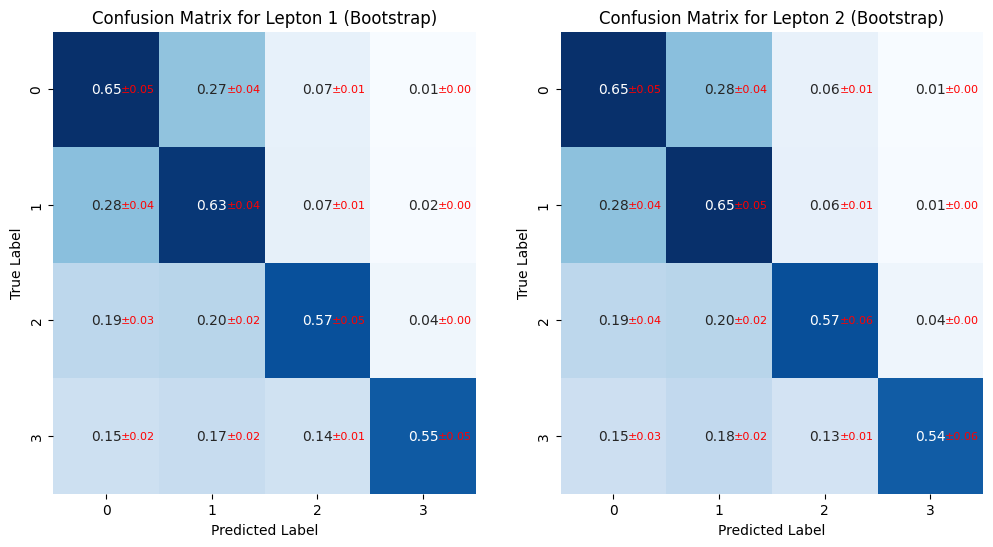

In [3]:
transformer.plot_confusion_matrix()

In [ ]:
transformer.plot_relative_variation_histogram(xlims=(-2,2))

In [ ]:
transformer.plot_binned_regression_accuracy("truth_ttbar_mass", "non_training", xlims=(340e3, 800e3))


In [ ]:
transformer.evaluate_accuracy()

In [ ]:
transformer.plot_prediction_2d_hist(xlims=(340e3, 800e3))